## Part 1: Data Inspection

In [0]:
import json
import numpy as np
f=open('labeled_small.json','r')
data=json.load(f)

In [0]:
import pandas as pd
# Create label for reviews, 1 for positive if review score is at least 14, and 0 otherwise
for d in data:
    if d['overall'] >= 14:
        d['label'] = 1
    else:
        d['label'] = 0
df = pd.DataFrame(data)
by_brewer = df.groupby(['brewer'])['overall'].describe()
by_beer = df.groupby(['beer_id'])['overall'].describe()

In [4]:
by_brewer.head()

,count,mean,std,min,25%,50%,75%,max
brewer,,,,,,,,
0,519.0,12.836224,2.545751,1.0,12.0,13.0,15.0,18.0
10,6300.0,14.141905,2.223685,1.0,13.0,14.0,16.0,20.0
58,13.0,12.769231,2.948272,4.0,12.0,14.0,14.0,16.0
61,62.0,11.112903,2.120198,6.0,10.0,11.5,13.0,16.0
66,3.0,13.666667,1.527525,12.0,13.0,14.0,14.5,15.0


In [5]:
by_beer.head()

,count,mean,std,min,25%,50%,75%,max
beer_id,,,,,,,,
1,3.0,14.0,3.000000,11.0,12.50,14.0,15.50,17.0
19,5.0,8.2,4.266146,2.0,6.00,9.0,12.00,12.0
21,1.0,13.0,NaN,13.0,13.00,13.0,13.00,13.0
24,2.0,11.5,0.707107,11.0,11.25,11.5,11.75,12.0
42,2.0,4.5,2.121320,3.0,3.75,4.5,5.25,6.0


The summary statistics by beer is not very reliable, since many beers only have few or even just one review. Looking at the summary statistics by brewer, we see that generally people have similar tastes. The standard deviation for slected brewers are usually around 2~3 points. 

## Part 2: Sentiment analysis

### (a). Generating Features

In [0]:
# loading necessary packages as well as loading vocab info
import scipy.sparse as sp
import numpy as np
with open('vocab_30.json','r') as g:
    vocab = json.load(g)
vocab_list = list(vocab.keys())

In [0]:
# splitting data into training, validation and testing sets with proportion 0.7:0.15:0.15
np.random.seed(123151)
n = len(data)
indexes = np.arange(n)
np.random.shuffle(indexes)

[train,validation,test] = np.split(indexes,[int(n*0.7),int(n*0.85)])
train_data = [data[i] for i in train]
validation_data = [data[i] for i in validation]
test_data = [data[i] for i in test]

In [0]:
import re
n_train = len(train_data)
p = len(vocab_list)
data_matrix = sp.lil_matrix((n_train,p))

In [0]:
for i in range(n_train):
    text = train_data[i]['review']
    text = text.lower()
    text = re.sub(r"\W+|_"," ",text)
    words = text.split()
    for word in words:
        if word in vocab_list:
            data_matrix[i,vocab[word]] = 1
    if (i % 1000) == 0:
      print(i)

In [0]:
data_matrix_sp = data_matrix.tocsr()

In [0]:
# do the same for validation data:
n_val = len(validation_data)
data_matrix_val = sp.lil_matrix((n_val,p))
for i in range(n_val):
    text = validation_data[i]['review']
    text = text.lower()
    text = re.sub(r"\W+|_"," ",text)
    words = text.split()
    for word in words:
        if word in vocab_list:
            data_matrix_val[i,vocab[word]] = 1

In [0]:
data_matrix_val_sp = data_matrix_val.tocsr()

In [0]:
# do the same for testing data:
n_test = len(test_data)
data_matrix_test = sp.lil_matrix((n_test,p))
for i in range(n_test):
    text = test_data[i]['review']
    text = text.lower()
    text = re.sub(r"\W+|_"," ",text)
    words = text.split()
    for word in words:
        if word in vocab_list:
            data_matrix_test[i,vocab[word]] = 1

In [0]:
data_matrix_test_sp = data_matrix_test.tocsr()

### (b). Logistic Loss vs. Hinge Loss

#### Logistic Loss:

When training logistic regression, I noticed that if max_iter is low, the algorithm does not converge. However, even when I set max_iter to be very high and wait for convergence, the error rate does not change by very much, so for the sake of speed and convenience I will let the max number of iteration to be low and use whatever coefficients that come out of the algorithm. 

In [0]:
from sklearn.linear_model import LogisticRegression

In [0]:
labels = df['label'].to_numpy()
train_labels = np.array([labels[i] for i in train])
validation_labels = np.array([labels[i] for i in validation])
test_labels = np.array([labels[i] for i in test])

In [0]:
import warnings
warnings.simplefilter('ignore')

lambda_grid = [100000,10000,1000,100,10,1,0.1,0.01]
error = []
nn = len(validation_labels)
for lamb in lambda_grid:
    lg = LogisticRegression(fit_intercept=True,C=lamb,penalty='l2',solver='saga')
    model = lg.fit(data_matrix_sp,train_labels)
    predicted = model.predict(data_matrix_val_sp)
    error_curr = ((predicted != validation_labels).sum()) / nn
    error.append(error_curr)

In [69]:
error

[0.23406666666666667,
 0.23413333333333333,
 0.23413333333333333,
 0.234,
 0.23406666666666667,
 0.23166666666666666,
 0.22553333333333334,
 0.23553333333333334]

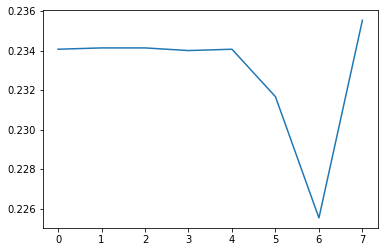

In [70]:
import matplotlib.pyplot as plt
plt.plot(range(len(lambda_grid)),error)

In [71]:
1/lambda_grid[6]

10.0

In [72]:
error[6]

0.22553333333333334

In [83]:
# Retrain the model on union of training and validation data, and get the test error
full_train = sp.vstack([data_matrix_sp,data_matrix_val_sp])
full_train_labels = np.concatenate([train_labels,validation_labels])
lg = LogisticRegression(fit_intercept=True,C=lambda_grid[6],penalty='l2',solver='saga')
model = lg.fit(full_train,full_train_labels)
predicted = model.predict(data_matrix_test_sp)
test_error = ((predicted != test_labels).sum()) / nn
test_error

0.2298

#### Hinge Loss:

In [0]:
from sklearn.svm import LinearSVC
error_SVC = []
for lamb in lambda_grid:
    svc = LinearSVC(penalty='l2',loss='hinge', C=lamb, fit_intercept=True, max_iter=1000)
    model = svc.fit(data_matrix_sp,train_labels)
    predicted = model.predict(data_matrix_val_sp)
    error_curr = ((predicted != validation_labels).sum()) / nn
    error_SVC.append(error_curr)

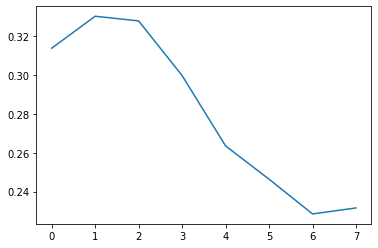

In [86]:
plt.plot(range(len(lambda_grid)),error_SVC)

In [87]:
1/lambda_grid[6]

10.0

In [88]:
error_SVC[6]

0.22853333333333334

In [90]:
svc = LinearSVC(penalty='l2',loss='hinge', C=lambda_grid[6], fit_intercept=True, max_iter=1000)
model = svc.fit(full_train,full_train_labels)
predicted = model.predict(data_matrix_test_sp)
test_error = ((predicted != test_labels).sum()) / nn
test_error

0.2318

#### Discussion

For both logistic regression classifier and SVC classifier, the optimal regularization parameter was 10, which is quite big but reasonable considering the large number of parameters and the sparsity of data. The error rates of the two methods are very close, although for the optimal case, logistic regression gives a slightly better error rate. Logistic regression takes very long to train, and if we reduce the number of iteration to hasten it, the algorithm does not converge. Nevertheless, the error rate for logistic regression is fine even without convergence of MLE algorithms. SVC on the other hand converges pretty fast. 

### (c). Stochastic gradient descenet

In [0]:
# Preprocess data to add intercept column. 
intercept_train = sp.csr_matrix(np.ones(len(train_labels)).reshape(len(train_labels),1))
intercept_val = sp.csr_matrix(np.ones(len(test_labels)).reshape(len(test_labels),1))
aug_data_train = sp.hstack([intercept_train,data_matrix_sp]).tocsr()
aug_data_val = sp.hstack([intercept_val,data_matrix_val_sp]).tocsr()
aug_data_test = sp.hstack([intercept_val,data_matrix_test_sp]).tocsr()

In [0]:
train_labels[train_labels==0] = -1
validation_labels[validation_labels==0] = -1
test_labels[test_labels==0] = -1

The update rules of stochastic gradient descent are as follow:
\begin{align}
\theta_{0}^{new} = \theta_{0}^{t} + \delta \sum_{i=1}^{n}\frac{y_{i}}{1+e^{2y_{i}\eta_{i}}} \\
\theta_{j}^{new} = \theta_{j}^{t} + \delta \left(\sum_{i=1}^{n} \frac{y_{i}x_{ij}}{1+e^{2y_{i}\eta_{i}}} - \lambda \theta_{j} \right)
\end{align}

The loss function is just the negative loglikelihood, which is:

\begin{equation}
C(\theta) = \sum_{i=1}^{n} log(1+e^{-2Y_{i}\eta_{i}}) + \lambda \|\theta\|^{2}
\end{equation}

The predicted probabilities from the model is:

\begin{align}
P(Y=1|X=x) &= \frac{1}{1+e^{-2\eta}} \\
P(Y=-1|X=x) &= \frac{1}{1+e^{2\eta}}
\end{align}

In [0]:
def neg_loglik(x,y,theta,lamb):
    eta = x.dot(theta)
    yeta = -2*np.multiply(y,eta)
    out = np.log(np.add(1,np.exp(yeta))).sum() + lamb* (np.power(theta,2).sum())
    return out

def predict_error(theta,x,labels):
    eta = x.dot(theta)
    probs = np.divide(1,np.add(1,np.exp(-2*eta)))
    probs[probs>=0.5] = 1
    probs[probs<0.5] = -1
    nn = len(labels)
    error = ((probs != labels).sum()) / nn
    return error 

def sgd_fixed(delta,lamb,x,y,epochs,batch_size,thresh=0.000001):
    # sgd for fixed learning rate 
    n,p = x.shape
    theta = np.zeros(p)
    lambmat = lamb*np.ones(p)
    lambmat[0] = 0
    errors = [predict_error(theta,aug_data_val,validation_labels)]
    # store errors 
    losses = [neg_loglik(x,y,theta,lamb)]
    # store losses
    indexes = np.arange(n)
    for epoch in range(epochs):
      np.random.shuffle(indexes)
      batch_index = np.r_[0:indexes.shape[0]:batch_size]
      batches = np.split(indexes,batch_index[1:])
      for batch in batches:
        k = batch.shape[0]
        xb = x[batch,:]
        yb = y[batch].reshape(k,1)
        eta = 2*xb.dot(theta)
        num = xb.multiply(yb)
        denom = np.add(1,np.exp(np.multiply(yb.flatten(),eta))).reshape(k,1)
        terms = ((num/denom).sum(axis=0) - np.multiply(lambmat,theta)).flatten()
        theta = np.asarray(theta + delta*terms).flatten()
        loss_curr = neg_loglik(x,y,theta,lamb)
        error_curr = predict_error(theta,aug_data_val,validation_labels)
        losses.append(loss_curr)
        errors.append(error_curr)
        if abs(losses[-1]-losses[-2]) < thresh:
          break
    res = [theta,errors,losses]
    return res

#### Step 1- Tuning for regularization parameter:

I will tentatively set the learning rate to be 0.001 as I observed that any higher rate seem to 
overshoot a bit with each steps (loss not decreasing). With that learning rate I will tune for the regularization parameter first. To make my life easier, I observe that in logistic regression and SVM part, losses tend to be smaller for large regularization parameters due to the high dimension of the data. So I will limit the range of my lambda to higher values. 

Also, I will perform this process on a subset of my full training data set. 

In [0]:
lambda_grid = [0.01,0.1,1,10,100]
sgd_res2 = []
for lamb in lambda_grid:
  res = sgd_fixed(0.001,lamb,aug_data_train[0:50000,:],train_labels[0:50000],25,1250)
  sgd_res2.append(res)

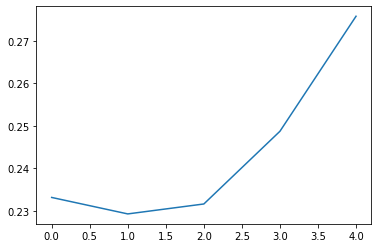

In [42]:
import matplotlib.pyplot as plt
min_error_sgd = []
for i in range(len(lambda_grid)):
  min_error = sgd_res2[i][1][-1]
  min_error_sgd.append(min_error)
plt.plot(range(len(lambda_grid)),min_error_sgd)

In [44]:
lambda_grid[1] # the lambda that produced the smallest error: 

0.1

Cross validation gives that $\lambda=0.1$ gives the smallest validation error, so I will use this $\lambda$ for subsequent analysis. Also note that the validation error is very close to the validation error of logistic regression and LinearSVC classifier. 

#### Step 2 - Trying out decreasing learning rates

I will try a decreasing learning rate with 
\begin{align}
\delta^{t+1} = \frac{\delta^{t}}{t^{1/50}}
\end{align}

and start with a higher learning rate of 0.01

In [0]:
def sgd_changing(delta,lamb,x,y,epochs,batch_size,thresh=0.000001):
    # sgd for fixed learning rate 
    n,p = x.shape
    theta = np.zeros(p)
    lambmat = lamb*np.ones(p)
    lambmat[0] = 0
    errors = [predict_error(theta,aug_data_val,validation_labels)]
    # store errors 
    losses = [neg_loglik(x,y,theta,lamb)]
    # store losses
    indexes = np.arange(n)
    t = 0
    for epoch in range(epochs):
      np.random.shuffle(indexes)
      batch_index = np.r_[0:indexes.shape[0]:batch_size]
      batches = np.split(indexes,batch_index[1:])
      for batch in batches:
        t = t+1
        delta = delta / (t**(1/10))
        k = batch.shape[0]
        xb = x[batch,:]
        yb = y[batch].reshape(k,1)
        eta = 2*xb.dot(theta)
        num = xb.multiply(yb)
        denom = np.add(1,np.exp(np.multiply(yb.flatten(),eta))).reshape(k,1)
        terms = ((num/denom).sum(axis=0) - np.multiply(lambmat,theta)).flatten()
        theta = np.asarray(theta + delta*terms).flatten()
        loss_curr = neg_loglik(x,y,theta,lamb)
        error_curr = predict_error(theta,aug_data_val,validation_labels)
        losses.append(loss_curr)
        errors.append(error_curr)
        if abs(losses[-1]-losses[-2]) < thresh:
          break
    res = [theta,errors,losses]
    return res

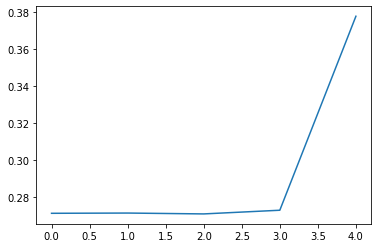

In [127]:
lambda_grid = [0.01,0.1,1,10,100]
sgd_res3 = []
for lamb in lambda_grid:
  res = sgd_changing(0.05,lamb,aug_data_train[0:50000,:],train_labels[0:50000],25,1250)
  sgd_res3.append(res)

min_error_sgd = []
for i in range(len(lambda_grid)):
  min_error = sgd_res3[i][1][-1]
  min_error_sgd.append(min_error)
plt.plot(range(len(lambda_grid)),min_error_sgd)


In [129]:
min_error_sgd

[0.271,
 0.27113333333333334,
 0.27066666666666667,
 0.27266666666666667,
 0.37793333333333334]

While implementing SGD with changing learning rate makes the convergence faster, it is very difficult to tune for the rate of decrease, and we see that the validation error for models trained from SGD with changing learning rate underperforms relative to models trained with fixed learning rate. Therefore, in subsequent analysis I will use SGD with fixed learning rate.

#### Step 3 - Training on the whole training set with optimal parameter, plot the error rate and negegative log-likelihood for both training and validation set as a function of iterations 

Based on the results from previous steps, I will SGD with fixed learning rate of 0.001, regularization parameter of $\lambda=0.1$,and maximum epoch of 25. I did not tune for batch size, but the validation error is in line with that of logistic regression, so I will keep using batch size of 1,250.

In [0]:
# add a component to sgd so that it keeps track of errors and losses 
# for both validation and training set.

def sgd_fixed(delta,lamb,x,y,epochs,batch_size,thresh=0.000001):
    # sgd for fixed learning rate 

    n,p = x.shape
    theta = np.zeros(p)
    lambmat = lamb*np.ones(p)
    lambmat[0] = 0

    # store errors
    errors = [predict_error(theta,aug_data_val,validation_labels)]
    errors_train = [predict_error(theta,x,y)]

    # store losses
    losses = [neg_loglik(x,y,theta,lamb)]
    losses_val = [neg_loglik(aug_data_val,validation_labels,theta,lamb)]

    indexes = np.arange(n)

    for epoch in range(epochs):
      # separate into random batches
      np.random.shuffle(indexes)
      batch_index = np.r_[0:indexes.shape[0]:batch_size]
      batches = np.split(indexes,batch_index[1:])

      for batch in batches:
        k = batch.shape[0]
        xb = x[batch,:]
        yb = y[batch].reshape(k,1)
        eta = 2*xb.dot(theta)
        num = xb.multiply(yb)
        denom = np.add(1,np.exp(np.multiply(yb.flatten(),eta))).reshape(k,1)
        terms = ((num/denom).sum(axis=0) - np.multiply(lambmat,theta)).flatten()
        theta = np.asarray(theta + delta*terms).flatten()
        loss_curr = neg_loglik(x,y,theta,lamb)
        loss_val_curr = neg_loglik(aug_data_val,validation_labels,theta,lamb)
        error_curr = predict_error(theta,aug_data_val,validation_labels)
        error_train_curr = predict_error(theta,x,y)
        losses.append(loss_curr)
        losses_val.append(loss_val_curr)
        errors.append(error_curr)
        errors_train.append(error_train_curr)
        if abs(losses[-1]-losses[-2]) < thresh:
          break

    res = [theta,errors_train,losses,errors,losses_val]
    return res

In [0]:
res = sgd_fixed(0.001,0.1,aug_data_train,train_labels,25,1250)

In [0]:
errors_train = res[1]
losses_train = res[2]
errors_val = res[3]
losses_val = res[4]

Text(0.5, 1.0, 'negative log likelihood of validation data')

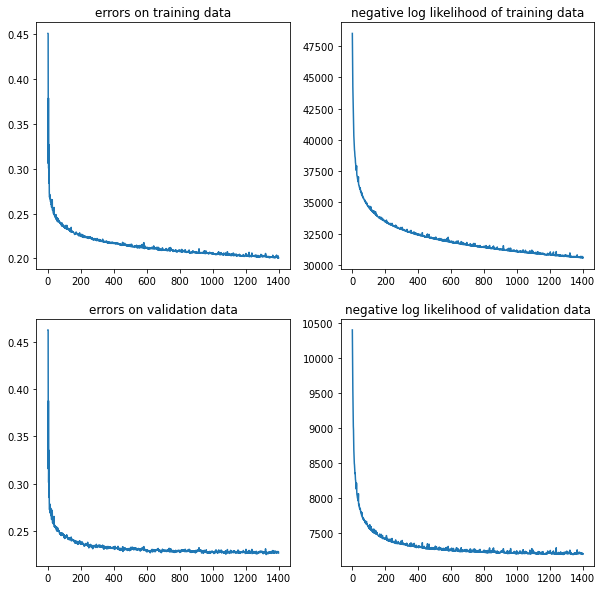

In [141]:
numiter = len(errors_train)

plt.figure(figsize=(10,10))

plt.subplot(2,2,1)
plt.plot(range(numiter),errors_train)
plt.title("errors on training data")

plt.subplot(2,2,2)
plt.plot(range(numiter),losses_train)
plt.title("negative log likelihood of training data")

plt.subplot(2,2,3)
plt.plot(range(numiter),errors_val)
plt.title("errors on validation data")

plt.subplot(2,2,4)
plt.plot(range(numiter),losses_val)
plt.title("negative log likelihood of validation data")

We see that stochastic gradient actually converges quite fast, with decrease in error and loss rapidly plateuaing at around 200 iterations. 

#### Step 4 - Train on union of training and validation set, report the error on the test set

I use the same parameters for SGD that I used in step 3 and train the model on the full training + validation data to get the prediction error on test data. 

In [146]:
full_train = sp.vstack([aug_data_train,aug_data_val])
full_train_labels = np.concatenate([train_labels,validation_labels])
res = sgd_fixed(0.001,0.1,full_train,full_train_labels,30,1250)
theta_hat = res[0]
test_error = predict_error(theta_hat,aug_data_test,test_labels)
test_error

0.23393333333333333

The prediction error on test data is 23%, which is close to the error rate on logistic regression and SVC classifier. 

## Part 3. Score versus text.

In [0]:
# Constructing the data matrix for training, validation, and testing set
from sklearn import preprocessing

scores = df[['appearance','aroma','palate','style','taste']].to_numpy()
train_scores = np.hstack([np.ones((len(train),1)),preprocessing.scale(scores[train])])
val_scores = np.hstack([np.ones((len(validation),1)),preprocessing.scale(scores[validation])])
test_scores = np.hstack([np.ones((len(test),1)),preprocessing.scale(scores[test])])

In [0]:
# Modify SGD code 
def sgd_fixed(delta,lamb,x,y,epochs,batch_size,thresh=0.000001):
    # sgd for fixed learning rate 
    n,p = x.shape
    theta = np.zeros(p)
    lambmat = lamb*np.ones(p)
    lambmat[0] = 0
    errors = [predict_error(theta,val_scores,validation_labels)]
    # store errors 
    losses = [neg_loglik(x,y,theta,lamb)]
    # store losses
    indexes = np.arange(n)
    for epoch in range(epochs):
      np.random.shuffle(indexes)
      batch_index = np.r_[0:indexes.shape[0]:batch_size]
      batches = np.split(indexes,batch_index[1:])
      for batch in batches:
        k = batch.shape[0]
        xb = x[batch,:]
        yb = y[batch].reshape(k,1)
        eta = 2*xb.dot(theta)
        num = np.multiply(xb,yb)
        denom = np.add(1,np.exp(np.multiply(yb.flatten(),eta))).reshape(k,1)
        terms = ((num/denom).sum(axis=0) - np.multiply(lambmat,theta)).flatten()
        theta = np.asarray(theta + delta*terms).flatten()
        loss_curr = neg_loglik(x,y,theta,lamb)
        error_curr = predict_error(theta,val_scores,validation_labels)
        losses.append(loss_curr)
        errors.append(error_curr)
        if abs(losses[-1]-losses[-2]) < thresh:
          break
    res = [theta,errors,losses]
    return res

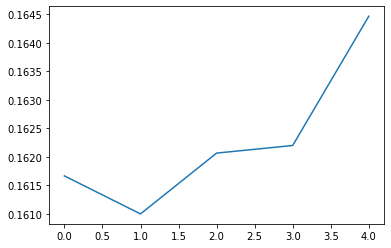

In [195]:
# Tuning for regularization parameters

lambda_grid = [0.01,0.1,1,10,100]
sgd_res_score = []
for lamb in lambda_grid:
  res = sgd_fixed(0.001,lamb,train_scores,train_labels,25,1250)
  sgd_res_score.append(res)

min_error_sgd = []
for i in range(len(lambda_grid)):
  min_error = sgd_res_score[i][1][-1]
  min_error_sgd.append(min_error)
plt.plot(range(len(lambda_grid)),min_error_sgd)

In [196]:
min_error_sgd

[0.16166666666666665, 0.161, 0.16206666666666666, 0.1622, 0.16446666666666668]

In [197]:
lambda_grid[1]

0.1

The optimal regularization parameter is the same as model using text data, which is 0.1. 

In [199]:
# Retraining the model on the union of training and validation set,
# Compute the prediction error on the testing set
full_train_score = np.vstack([train_scores,val_scores])
res = sgd_fixed(0.001,0.1,full_train_score,full_train_labels,25,1250)
res[1][-1]

0.16206666666666666

#### Discussion:

The model using scores has lower prediction error on test data. The precise error rate can be influenced by various factors which I did not tune for, including batch size and learning rate I used for each type of models.

However, in general, it could be said that the model using scores is more straightforward, and intuitively, scores has a more direct relationship to overall scores, as both are numerical variables.

Model using text could be very noisy if the vocabularies are not picked with care. Even when vocabularies are picked with care, the same word can mean many different things depending on context, and sometimes words are used sarcastically. We might need to even consider representing words in n-pules to capture more of the sentimental context of a text. 

Someone who thinks that a beer is bad could leave a straightforward criticism or a very sarcastic comment. However, if they are being honest, they will definitely leave a low score, which is far easier to detect and model into our prediction. 